## General Imports and Adding Source Code to Path

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
relative_path_to_source = '../haystack/' # My relative path to the multi-penalty source code
sys.path.append(relative_path_to_source)

## Project Specific Imports

In [24]:
from src.error_analysis import run_error_analysis_inlier_noise
from src.plotting import plot_error_inlier_noise
from src.point_generator_manifold import from_1d_parametrisation_with_basepoints, inflate_ambient_space
from src.utils import extract_d_dim_principal_space
from src.reaper_translated import reaper_matlab
from sklearn.decomposition import PCA

## Problem Set-Up #1


#### Manifold function

In [3]:
def infl_sinus_curve(x, amplitude, inflated_by = 10):
    return inflate_ambient_space(sinus_curve, inflated_by)

def s_curve_manifold(t, derivative = 0):
    if derivative == 1:
        # Tangent vector
        return np.array([1.0, 3.0 * (t**2) - 1.0])
    elif derivative == -1:
        # Normal vector (normalised)
        return normal_nd(s_curve_manifold(t, derivative = 1))
    else:
        return np.array([t, t**3 - t])

#### Create solution under optimal conditons as best $\mathcal{L}_1$-fitting plane to the curve

In [4]:
%%capture
# Dimensions
ambient_dim = 200

# Function to describe manifold
f_manifold = inflate_ambient_space(s_curve_manifold, ambient_dim - 1)

# Number of outliers and inliers
outlier_points = 1
inlier_points = 100
total_points = outlier_points + inlier_points

# Spreads
inlier_spreads = 4.0
a = -2.0
b = a + inlier_spreads
outlier_spreads = 0.5

# inlier/outlier samples
inliers, outliers = from_1d_parametrisation_with_basepoints(a, b, f_manifold, outlier_points + inlier_points,
                                                            outlier_spreads)

# Randomly chose inlier_points inlier and take the rest as outliers
permuted_indices = np.random.permutation(list(range(0, total_points-1)))
inlier_indices = permuted_indices[:inlier_points]
outlier_indices = permuted_indices[inlier_points:]
inliers = inliers[:,inlier_indices]
outliers = outliers[:,outlier_indices]
X = np.hstack((inliers, outliers))

#### Solving the Problem

In [5]:
%%capture
d = 1
optimal_orthoprojector = reaper_matlab(X.T, d, spherical = "False")
optimal_orthoprojector_postprocessed = extract_d_dim_principal_space(optimal_orthoprojector, d)

#### Set n_outlier/n_inlier = 5 and check wrt to outlier noise

In [52]:
%%capture
# Dimensions
ambient_dim = 200

# Function to describe manifold
f_manifold = inflate_ambient_space(s_curve_manifold, ambient_dim - 1)

# Number of outliers and inliers
outlier_points = 30
inlier_points = 20
total_points = outlier_points + inlier_points

# Spreads
inlier_spreads = 4.0
a = -2.0
b = a + inlier_spreads
outlier_spreads = [0.005, 0.01, 0.1, 0.25, 0.5,0.75, 1.0, 1.25]

#### Solving the problems

Not reached convergence


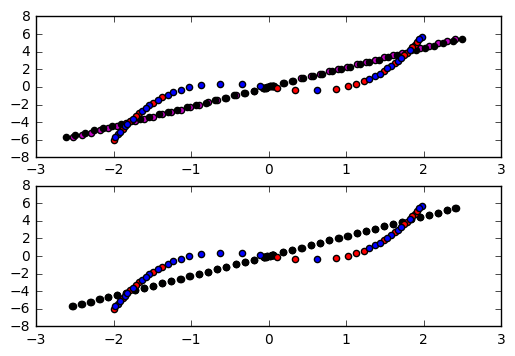

Not reached convergence


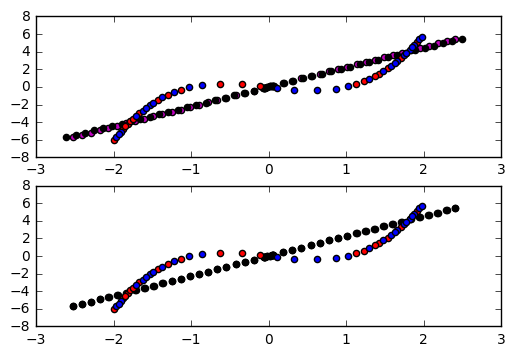

Not reached convergence


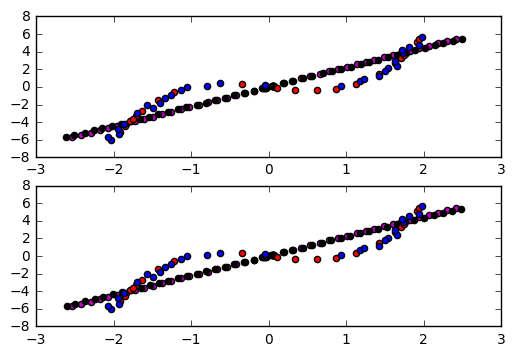

Not reached convergence


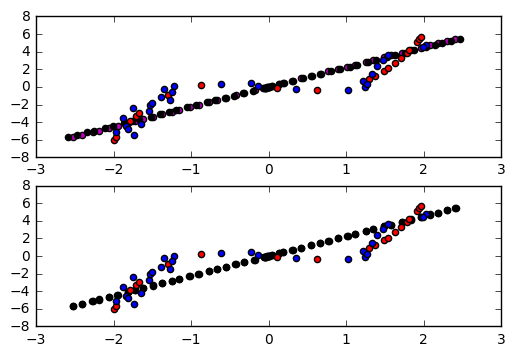

Not reached convergence


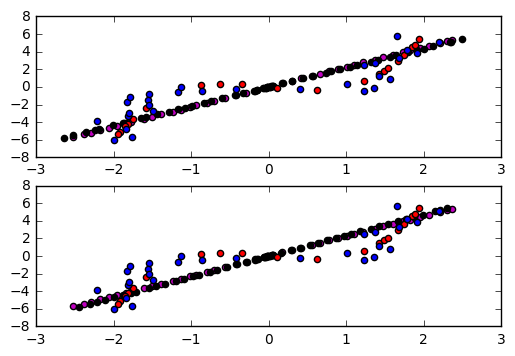

Not reached convergence


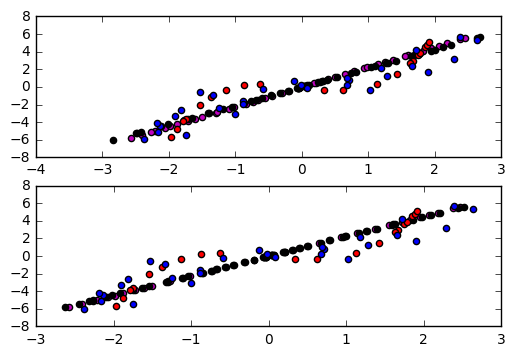

Not reached convergence


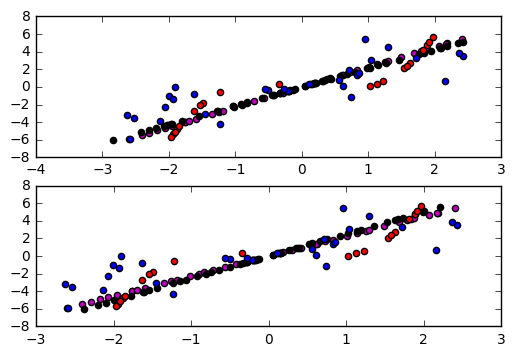

Not reached convergence


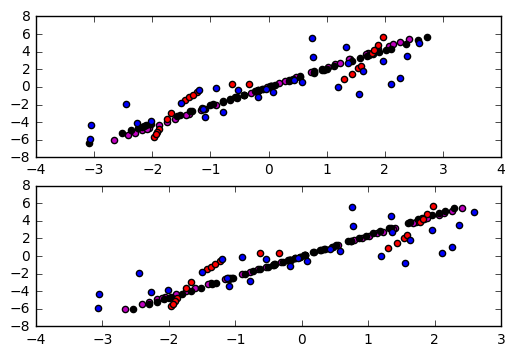

In [75]:
# Error vectors
errors = np.zeros(len(outlier_spreads))
errors_l2 = np.zeros(len(outlier_spreads))
errors_inlier_distance = np.zeros(len(outlier_spreads))
errors_inlier_distance_l2 = np.zeros(len(outlier_spreads))
optimal_inlier_distance = np.zeros(len(outlier_spreads))

pca = PCA(n_components = 1)

# inlier/outlier samples
for i, outlier_spread in enumerate(outlier_spreads):
    inliers, outliers = from_1d_parametrisation_with_basepoints(a, b, f_manifold, 
                                                                outlier_points + inlier_points,
                                                                outlier_spread)
    # Randomly chose inlier_points inlier and take the rest as outliers
    permuted_indices = np.random.permutation(list(range(0, total_points-1)))
    inlier_indices = permuted_indices[:inlier_points]
    outlier_indices = permuted_indices[inlier_points:]
    inliers = inliers[:,inlier_indices]
    outliers = outliers[:,outlier_indices]
    X = np.hstack((inliers, outliers))
    d = 1
    orthoprojector = reaper_matlab(X.T, d, spherical = "False")
    pca.fit(X.T)
    first_component = pca.components_[0,:]
    orthoprojector_l2 = np.outer(first_component,first_component)
    P_l2_postprocessed = extract_d_dim_principal_space(orthoprojector_l2, d)
    P_postprocessed = extract_d_dim_principal_space(orthoprojector, d)
    optimal_projected_points = optimal_orthoprojector_postprocessed.dot(X)
    optimal_inlier_distance[i] = np.linalg.norm(optimal_projected_points[:,:inlier_points] - X[:,:inlier_points],'fro')
    projected_points_l2 = P_l2_postprocessed.dot(X)
    f, ax = plt.subplots(2)
    ax[0].scatter(optimal_projected_points[0,:], optimal_projected_points[1,:], c='m')
    ax[0].scatter(projected_points_l2[0,:], projected_points_l2[1,:], c='k')
    ax[0].scatter(inliers[0,:], inliers[1,:], c = 'r')
    ax[0].scatter(outliers[0,:], outliers[1,:], c = 'b')
    # Errors L2
    errors_l2[i] = np.linalg.norm(optimal_orthoprojector_postprocessed - P_l2_postprocessed)/np.linalg.norm(optimal_orthoprojector_postprocessed)
    errors_inlier_distance_l2[i] = np.linalg.norm(projected_points_l2[:,:inlier_points] - X[:,:inlier_points],'fro')
    projected_points = P_postprocessed.dot(X)
    ax[1].scatter(optimal_projected_points[0,:], optimal_projected_points[1,:], c='m')
    ax[1].scatter(projected_points[0,:], projected_points[1,:], c='k')
    ax[1].scatter(inliers[0,:], inliers[1,:], c = 'r')
    ax[1].scatter(outliers[0,:], outliers[1,:], c = 'b')
    # Errors Reaper
    errors[i] = np.linalg.norm(optimal_orthoprojector_postprocessed - P_postprocessed)/np.linalg.norm(optimal_orthoprojector_postprocessed)
    errors_inlier_distance[i] = np.linalg.norm(projected_points[:,:inlier_points] - X[:,:inlier_points],'fro')
    plt.show()

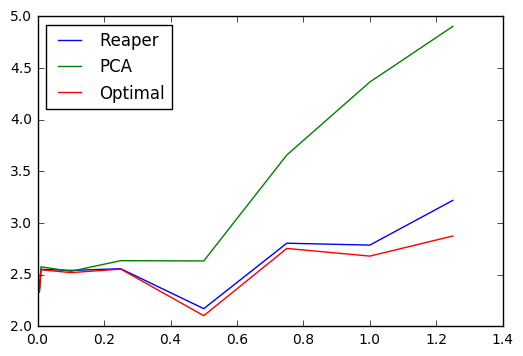

In [83]:
plt.plot(outlier_spreads, errors_inlier_distance, label = 'Reaper')
plt.plot(outlier_spreads, errors_inlier_distance_l2, label = 'PCA')
plt.plot(outlier_spreads, optimal_inlier_distance, label = 'Optimal')
plt.legend(loc = 'upper left')
plt.show()

## Problem Set-Up #2


#### Manifold function

In [77]:
def infl_sinus_curve(x, amplitude, inflated_by = 10):
    return inflate_ambient_space(sinus_curve, inflated_by)

def s_curve_manifold(t, derivative = 0):
    if derivative == 1:
        # Tangent vector
        return np.array([1.0, 3.0 * (t**2) - 1.0])
    elif derivative == -1:
        # Normal vector (normalised)
        return normal_nd(s_curve_manifold(t, derivative = 1))
    else:
        return np.array([t, t**3 - t])

#### Create solution under optimal conditons as best $\mathcal{L}_1$-fitting plane to the curve

In [78]:
%%capture
# Dimensions
ambient_dim = 200

# Function to describe manifold
f_manifold = inflate_ambient_space(s_curve_manifold, ambient_dim - 1)

# Number of outliers and inliers
outlier_points = 1
inlier_points = 100
total_points = outlier_points + inlier_points

# Spreads
inlier_spreads = 4.0
a = -2.0
b = a + inlier_spreads
outlier_spreads = 0.5

# inlier/outlier samples
inliers, outliers = from_1d_parametrisation_with_basepoints(a, b, f_manifold, outlier_points + inlier_points,
                                                            outlier_spreads)

# Randomly chose inlier_points inlier and take the rest as outliers
permuted_indices = np.random.permutation(list(range(0, total_points-1)))
inlier_indices = permuted_indices[:inlier_points]
outlier_indices = permuted_indices[inlier_points:]
inliers = inliers[:,inlier_indices]
outliers = outliers[:,outlier_indices]
X = np.hstack((inliers, outliers))

#### Solving the Problem

In [79]:
%%capture
d = 1
optimal_orthoprojector = reaper_matlab(X.T, d, spherical = "False")
optimal_orthoprojector_postprocessed = extract_d_dim_principal_space(optimal_orthoprojector, d)

#### Set n_outlier/n_inlier = 5 and check wrt to outlier noise

In [80]:
%%capture
# Dimensions
ambient_dim = 200

# Function to describe manifold
f_manifold = inflate_ambient_space(s_curve_manifold, ambient_dim - 1)

# Number of outliers and inliers
outlier_points = 100
inlier_points = 20
total_points = outlier_points + inlier_points

# Spreads
inlier_spreads = 4.0
a = -2.0
b = a + inlier_spreads
outlier_spreads = [0.005, 0.01, 0.1, 0.25, 0.5,0.75, 1.0, 1.25]

#### Solving the problems

Not reached convergence


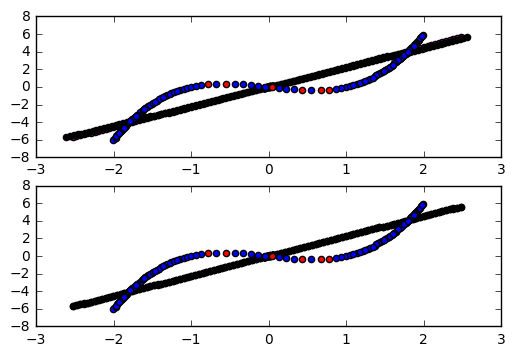

Not reached convergence


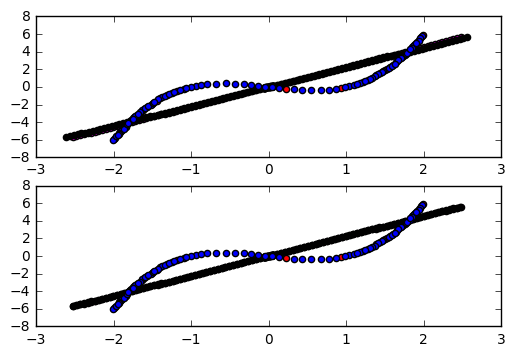

Not reached convergence


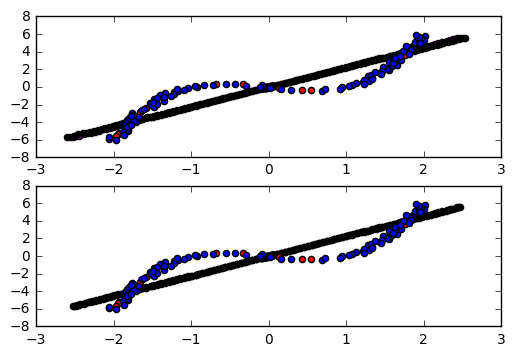

Not reached convergence


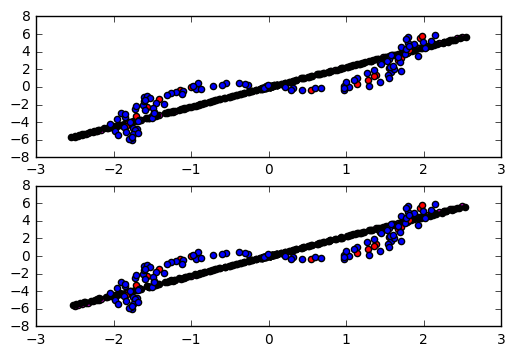

Not reached convergence


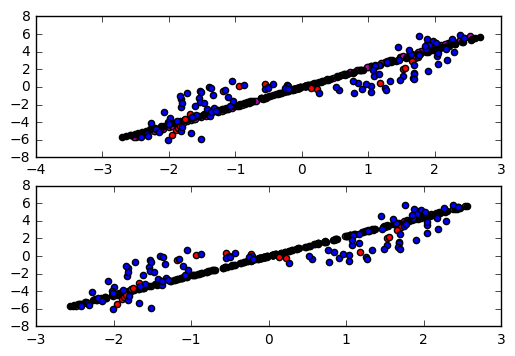

Not reached convergence


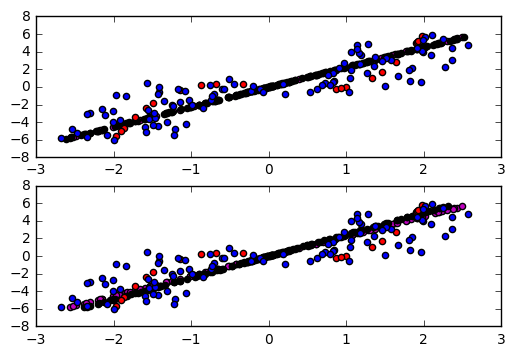

Not reached convergence


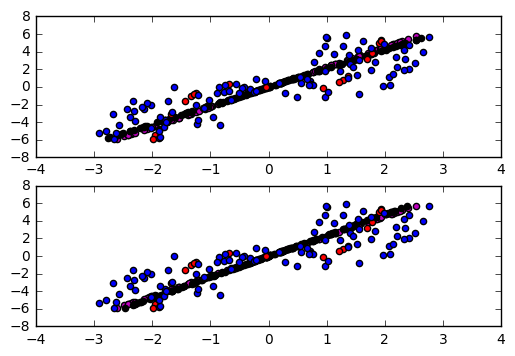

Not reached convergence


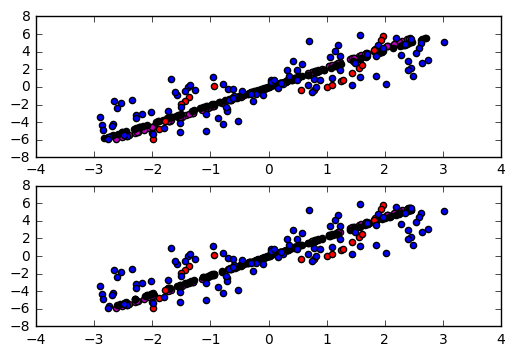

In [81]:
# Error vectors
errors = np.zeros(len(outlier_spreads))
errors_l2 = np.zeros(len(outlier_spreads))
errors_inlier_distance = np.zeros(len(outlier_spreads))
errors_inlier_distance_l2 = np.zeros(len(outlier_spreads))
optimal_inlier_distance = np.zeros(len(outlier_spreads))

pca = PCA(n_components = 1)

# inlier/outlier samples
for i, outlier_spread in enumerate(outlier_spreads):
    inliers, outliers = from_1d_parametrisation_with_basepoints(a, b, f_manifold, 
                                                                outlier_points + inlier_points,
                                                                outlier_spread)
    # Randomly chose inlier_points inlier and take the rest as outliers
    permuted_indices = np.random.permutation(list(range(0, total_points-1)))
    inlier_indices = permuted_indices[:inlier_points]
    outlier_indices = permuted_indices[inlier_points:]
    inliers = inliers[:,inlier_indices]
    outliers = outliers[:,outlier_indices]
    X = np.hstack((inliers, outliers))
    d = 1
    orthoprojector = reaper_matlab(X.T, d, spherical = "False")
    pca.fit(X.T)
    first_component = pca.components_[0,:]
    orthoprojector_l2 = np.outer(first_component,first_component)
    P_l2_postprocessed = extract_d_dim_principal_space(orthoprojector_l2, d)
    P_postprocessed = extract_d_dim_principal_space(orthoprojector, d)
    optimal_projected_points = optimal_orthoprojector_postprocessed.dot(X)
    optimal_inlier_distance[i] = np.linalg.norm(optimal_projected_points[:,:inlier_points] - X[:,:inlier_points],'fro')
    projected_points_l2 = P_l2_postprocessed.dot(X)
    f, ax = plt.subplots(2)
    ax[0].scatter(optimal_projected_points[0,:], optimal_projected_points[1,:], c='m')
    ax[0].scatter(projected_points_l2[0,:], projected_points_l2[1,:], c='k')
    ax[0].scatter(inliers[0,:], inliers[1,:], c = 'r')
    ax[0].scatter(outliers[0,:], outliers[1,:], c = 'b')
    # Errors L2
    errors_l2[i] = np.linalg.norm(optimal_orthoprojector_postprocessed - P_l2_postprocessed)/np.linalg.norm(optimal_orthoprojector_postprocessed)
    errors_inlier_distance_l2[i] = np.linalg.norm(projected_points_l2[:,:inlier_points] - X[:,:inlier_points],'fro')
    projected_points = P_postprocessed.dot(X)
    ax[1].scatter(optimal_projected_points[0,:], optimal_projected_points[1,:], c='m')
    ax[1].scatter(projected_points[0,:], projected_points[1,:], c='k')
    ax[1].scatter(inliers[0,:], inliers[1,:], c = 'r')
    ax[1].scatter(outliers[0,:], outliers[1,:], c = 'b')
    # Errors Reaper
    errors[i] = np.linalg.norm(optimal_orthoprojector_postprocessed - P_postprocessed)/np.linalg.norm(optimal_orthoprojector_postprocessed)
    errors_inlier_distance[i] = np.linalg.norm(projected_points[:,:inlier_points] - X[:,:inlier_points],'fro')
    plt.show()

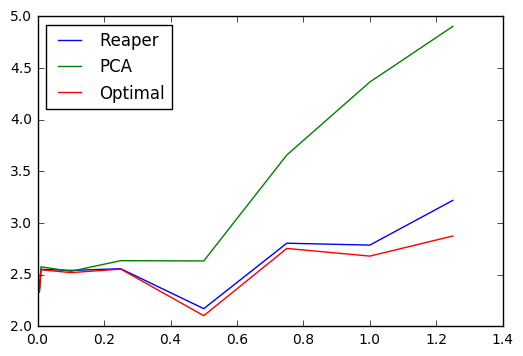

In [82]:
plt.plot(outlier_spreads, errors_inlier_distance, label = 'Reaper')
plt.plot(outlier_spreads, errors_inlier_distance_l2, label = 'PCA')
plt.plot(outlier_spreads, optimal_inlier_distance, label = 'Optimal')
plt.legend(loc = 'upper left')
plt.show()

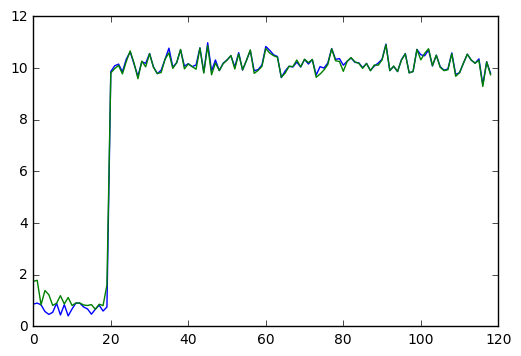

In [92]:
plt.plot(np.linalg.norm(projected_points - X, axis = 0))
plt.plot(np.linalg.norm(projected_points_l2 - X, axis = 0))
plt.show()